## Background

Basic example extracting various Sentinel-2 data within Greater Manchester and calculating the Enhanced Normalised Difference Impervious Surfaces Index (ENDISI) based on [Chen et al. (2019)](https://www.spiedigitallibrary.org/journals/journal-of-applied-remote-sensing/volume-13/issue-01/016502/Enhanced-normalized-difference-index-for-impervious-surface-area-estimation-at/10.1117/1.JRS.13.016502.full).

## Libraries

In [ ]:
from pathlib import Path

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage.filters import threshold_otsu

from download.setup.constants import Paths

crs_val = 27700

Read data.

In [ ]:
gdf = gpd.read_parquet(
    Paths.RAW_DATA_DIR / "boundaries" / "geom-mca-codes_2024.parquet",
    filters=[("CAUTH24CD", "=", "E47000001")],
).to_crs(crs_val)


def read_raster(path: Path, band_rename: list[str]) -> xr.Dataset:
    data = xr.open_dataarray(path)
    data = data.assign_coords(band=band_rename)
    return data.rio.clip(gdf.geometry, all_touched=True)


baseline = read_raster(
    path=Paths.RAW_DATA_DIR / "earth_observation" / "rgb_swir_composite__2023.tif",
    band_rename=["red", "green", "blue", "swir1", "swir2"],
)

analysis = read_raster(
    path=Paths.RAW_DATA_DIR / "earth_observation" / "rgb_swir_composite__2024.tif",
    band_rename=["red", "green", "blue", "swir1", "swir2"],
)

Plot all bands.

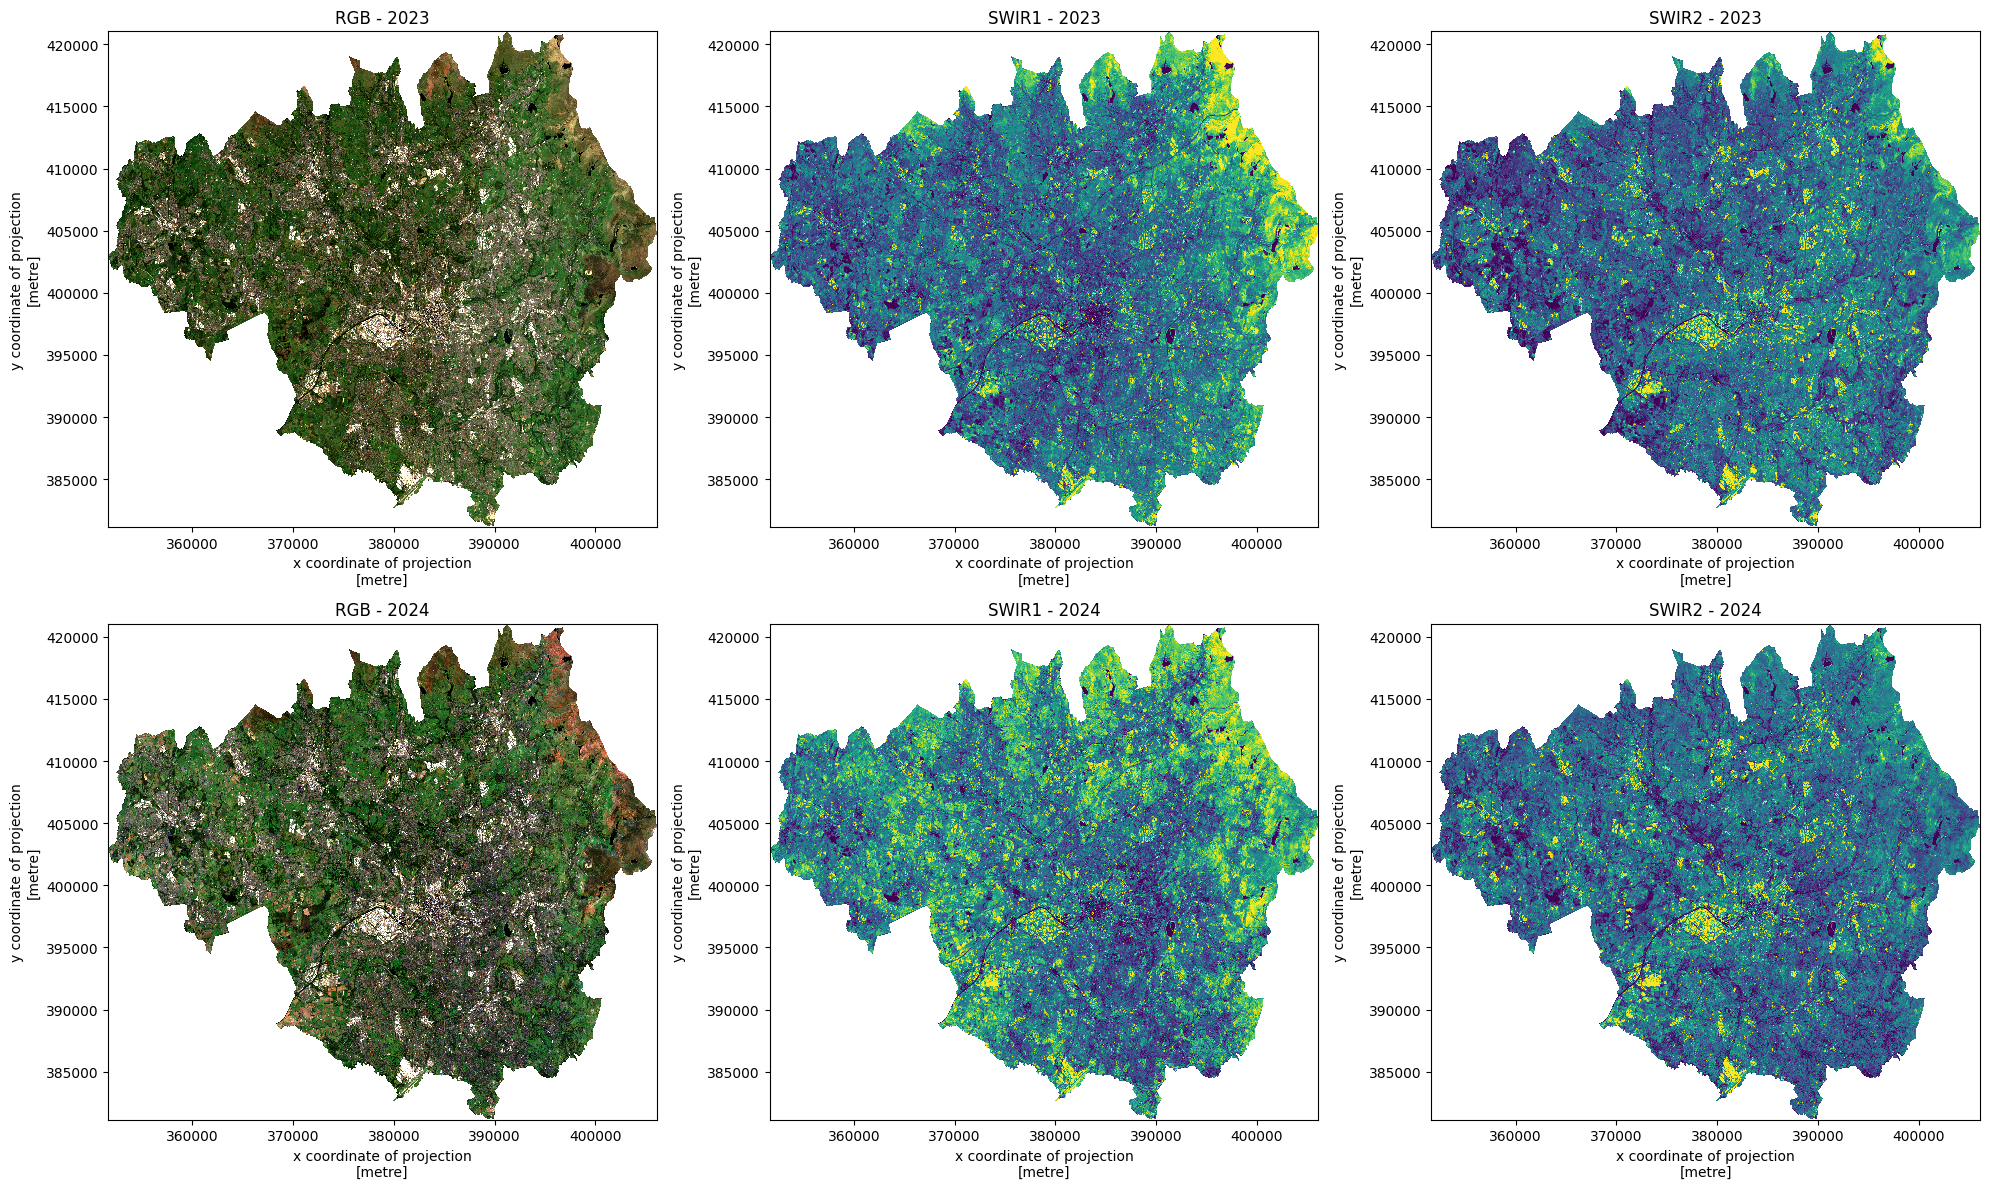

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

datasets = [baseline, analysis]
years = [2023, 2024]
bands = ["RGB", "swir1", "swir2"]
titles = [
    [f"RGB - {years[0]}", f"SWIR1 - {years[0]}", f"SWIR2 - {years[0]}"],
    [f"RGB - {years[1]}", f"SWIR1 - {years[1]}", f"SWIR2 - {years[1]}"],
]

for row_idx, (data, year) in enumerate(zip(datasets, years)):
    for col_idx, band in enumerate(bands):
        ax = axes[row_idx][col_idx]
        if band == "RGB":
            data.sel(band=["red", "green", "blue"]).plot.imshow(ax=ax, robust=True)
        else:
            data.sel(band=band).plot.imshow(
                ax=ax, cmap="viridis", robust=True, add_colorbar=False
            )
        ax.set_title(titles[row_idx][col_idx])

plt.tight_layout()

In [ ]:
def calculate_endisi(xds: xr.Dataset) -> xr.DataArray:
    """Calculate Enhanced Normalised Difference Impervious Surfaces Index.

    Based on Chen et al. 2019.
    """
    def mndwi(xds: xr.Dataset): # noqa: ANN202
        return (xds.sel(band="green") - xds.sel(band="swir1")) / (
            xds.sel(band="green") + xds.sel(band="swir1")
        )

    def swir_diff(xds: xr.Dataset):  # noqa: ANN202
        return xds.sel(band="swir1") / xds.sel(band="swir2")

    def alpha(xds:xr.Dataset): # noqa: ANN202
        return (2 * (np.mean(xds.sel(band="blue")))) / (
            np.mean(swir_diff(xds)) + np.mean(mndwi(xds) ** 2)
        )

    m = mndwi(xds)
    s = swir_diff(xds)
    a = alpha(xds)

    return (xds.sel(band="blue") - (a) * (s + m**2)) / (
        xds.sel(band="blue") + (a) * (s + m**2)
    )

endisi_baseline = calculate_endisi(baseline)
endisi_analysis = calculate_endisi(analysis)

Plot ENDISI values.

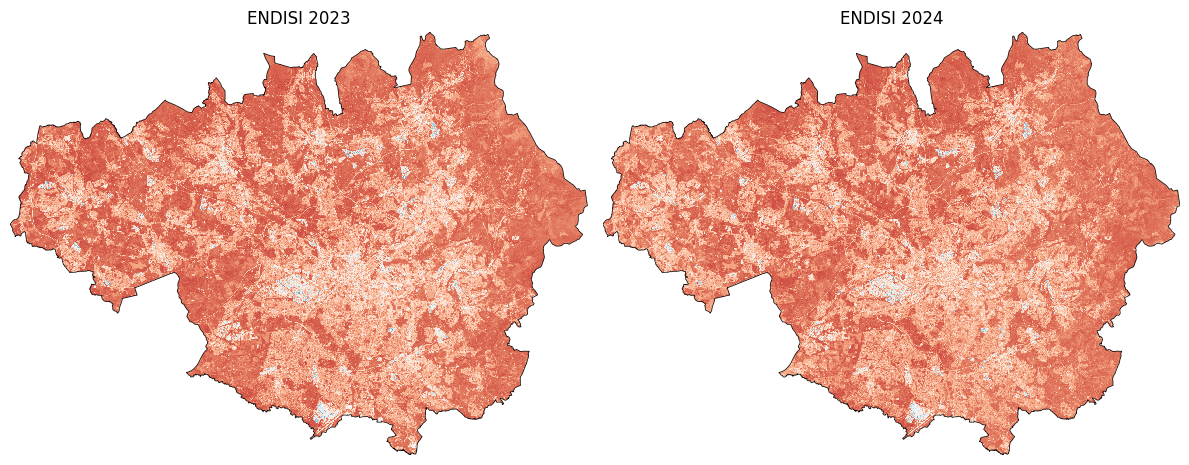

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

datasets = [endisi_baseline, endisi_analysis]
years = [2023, 2024]

kwargs = {
    "vmin": -0.75,
    "vmax": 0.75,
    "cmap": "RdBu",
    "robust": True,
    "add_colorbar": False,
}

for ax, data, year in zip(axes, datasets, years):
    data.plot(ax=ax, **kwargs)
    gdf.boundary.plot(ax=ax, color="black", lw=0.5)
    ax.set_axis_off()
    ax.set_title(f"ENDISI {year}")

plt.tight_layout()

Automatic threshold selector.

In [ ]:
def calculate_threshold(data: xr.Dataset) -> xr.DataArray:
    """Helper to automate threshold selection."""
    data_no_na = data.fillna(data.mean().values)
    threshold = threshold_otsu(data_no_na.values)
    print(f"ENDISI value: {round(threshold, 2)}")
    return (data_no_na, threshold)

(endisi_no_na_baseline, threshold_baseline) = calculate_threshold(endisi_baseline)
(endisi_no_na_analysis, threshold_analysis) = calculate_threshold(endisi_analysis)

ENDISI value: -0.27
ENDISI value: -0.27


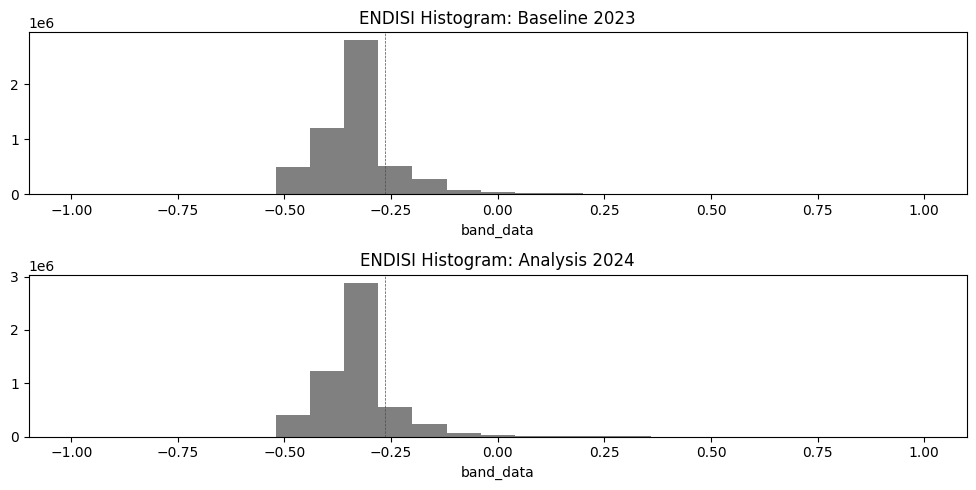

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

datasets = [endisi_no_na_baseline, endisi_no_na_analysis]
titles = ["Baseline", "Analysis"]
years = [2023, 2024]
kwargs = {"bins": 25, "range": (-1, 1), "facecolor": "gray"}

for ax, data, title, year in zip(axes, datasets, titles, years):
    data.plot.hist(ax=ax, **kwargs)
    ax.axvline(threshold_baseline, color="red", linestyle="--", linewidth=0.5)
    ax.set_title(f"ENDISI Histogram: {title} {year}")

plt.tight_layout()

In [ ]:
def create_urban_mask(data: xr.DataArray, threshold) -> xr.DataArray:
    """Helper to create a proxy urban mask based on endisi & threshold."""
    urban_area = (data > threshold).astype(int)
    return urban_area.where(urban_area != 0, np.nan)

urban_area_2023 = create_urban_mask(endisi_no_na_baseline, threshold_baseline)
urban_area_2024 = create_urban_mask(endisi_no_na_analysis, threshold_analysis)

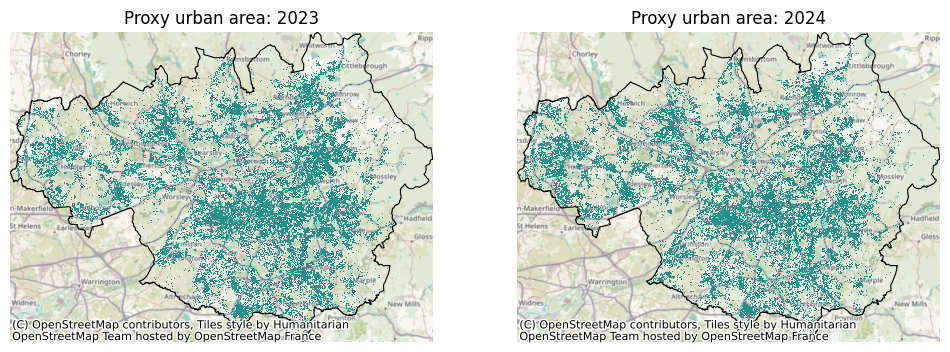

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

kwargs = {
    "robust": True,
    "add_colorbar": False,
}

datasets = [urban_area_2023, urban_area_2024]

years = [2023, 2024]

for ax, data, year in zip(axes, datasets, years):
    data.plot(ax=ax, **kwargs)
    gdf.boundary.plot(ax=ax, lw=0.8, color="black")
    ctx.add_basemap(ax, crs=crs_val)
    ax.set_axis_off()
    ax.set_title(f"Proxy urban area: {year}")

Marginal difference between years.

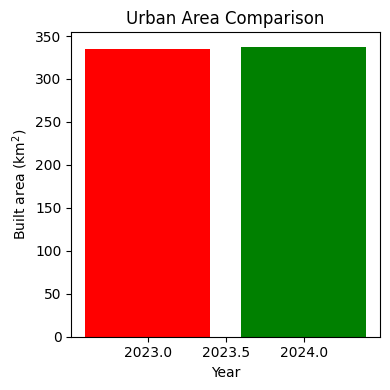

In [87]:
pixel_length = 20  # in metres
area_per_pixel = pixel_length**2 / 1000**2

years = [2023, 2024]

urban_areas_km2 = [
    data.sum(dim=["x", "y"]).item() * area_per_pixel for data in datasets
]

fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(years, urban_areas_km2, width=0.8, color=["red", "green"])

ax.set_xlabel("Year")
ax.set_ylabel("Built area (km$^2$)")
ax.set_title("Urban Area Comparison")
plt.tight_layout()

Not much change, should look at a separate year.

Text(0.5, 1.0, 'Urban Change')

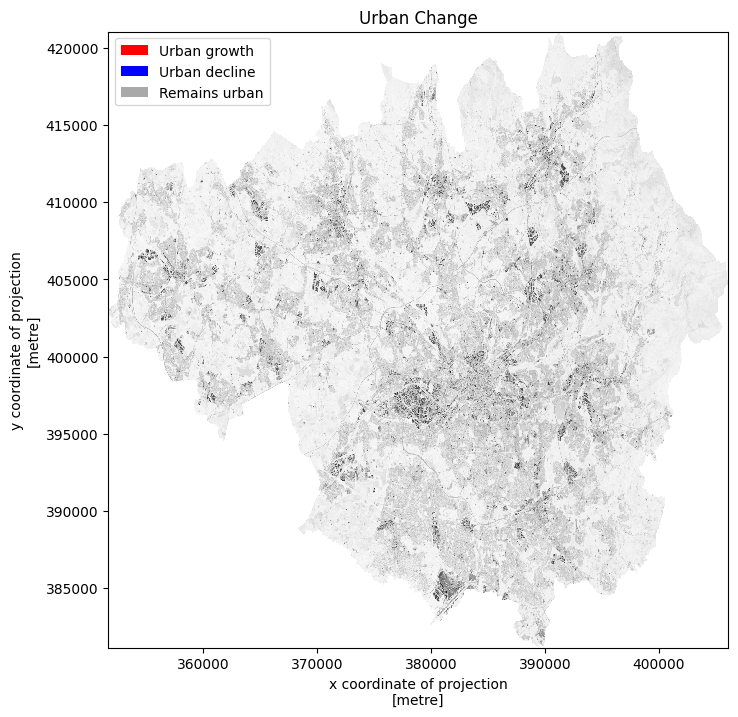

In [ ]:
colors = {
    "growth": "red",
    "decline": "blue",
    "baseline": "darkgrey",
}

urban_change = endisi_analysis - endisi_baseline
urban_growth = urban_change.where(urban_change == 1)
urban_decline = urban_change.where(urban_change == -1)

plot = endisi_baseline.plot(
    size=8,
    aspect=1,
    cmap="Greys",
    add_colorbar=False,
)

for data, color in [
    (urban_growth, colors["growth"]),
    (urban_decline, colors["decline"]),
]:
    data.plot(
        ax=plot.axes,
        cmap=ListedColormap([color]),
        add_colorbar=False,
        add_labels=False,
    )

legend_elements = [
    Patch(facecolor=colors["growth"], label="Urban growth"),
    Patch(facecolor=colors["decline"], label="Urban decline"),
    Patch(facecolor=colors["baseline"], label="Remains urban"),
]
plot.axes.legend(handles=legend_elements, loc="upper left")

plt.title("Urban Change")